In [110]:
!pip install tabulate --user

Looking in links: https://repoman.ornl.gov/pypi/web/simple


# Import Stuff here

In [259]:
import os
import sys
import re
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
from tabulate import tabulate
import matplotlib.pyplot as plt

### Define paths here

In [130]:
MAIN_DIR = os.getcwd()
print(MAIN_DIR)

/SNS/snfs1/instruments-hfir/HB3/IPTS-34735/exp823/Shared/GY_scripts


In [131]:
DATA_DIR = '/SNS/snfs1/instruments-hfir/HB3/IPTS-34735/exp823/Datafiles'

### Define functions here

In [177]:
def data_reader(scannumber):
    comments = []
    header = []
    footer = []
    with open('{}/HB3_exp0823_scan0{}.dat'.format(DATA_DIR, scannumber)) as f:
        data = f.readlines()
    #for x in data[29:]:
    #    print(x)
    for i in range(29):
        comments.append(data.pop(0))
    header.append(data.pop(0))
    for i in range(4):
        footer.append(data.pop(-1))

    datarray = []
    for i in data:
        datarray.append(np.array(i.split(), dtype='float'))
    return(comments, header, footer, datarray)

In [178]:
def which_command(comment):
    for line in comment:
        if '# command =' in line:
            #print(line)
            return(line)

In [179]:
def what_scan(command_line):
    # Use regular expression to find values for h, k, l, e, ef, and mcu
    match = re.search(r'h (\S+) k (\S+) l (\S+) e (\S+).* ef (\S+).* mcu (\S+)', command_line)
    if match:
        h = match.group(1)
        k = match.group(2)
        l = match.group(3)
        e = match.group(4)
        ef = match.group(5)
        mcu = match.group(6)

        #print("h:", h)
        #print("k:", k)
        #print("l:", l)
        #print("e:", e)
        #print("ef:", ef)
        #print("mcu:", mcu)
        return([float(h), float(k), float(l)], float(e), float(ef), float(mcu))


In [180]:
def all_scans_table(scans):
    table_data = []
    for i in scans:
        comments, header, footer, datarray = data_reader(i)
        command = which_command(comments)
        result = what_scan(command)
        if result:
            table_data.append([i] + result[0] + [result[1], result[2], result[3]])
        
    df = pd.DataFrame(table_data, columns=["Scan#", "h", "k", "l", "e", "ef", "mcu"])
    pd.set_option("display.max_rows", None)    # Show all rows
    pd.set_option("display.max_columns", None) # Show all columns
    pd.set_option("display.width", None)       # No limit on column width
    pd.set_option("display.max_colwidth", None) # Show full column content
    print(df)
    #print(tabulate(df, headers="keys", tablefmt="fancy_grid", showindex=False))

### Use the command below to print a table of the scans 

In [182]:
#all_scans_table(scans)

### Actual data processing done here -- Define data processing functions

In [235]:
scans = [str(x).zfill(3) for x in range(134, 146, 1)]

In [236]:
comments, header, footer, datarray = data_reader(scans[0])

In [237]:
header

['#   Pt.          h          k          l          e         ef       time   detector    monitor        mcu focal_length         m1         m2   mcrystal       marc     mtrans     mfocus         s1         s2        sgl        sgu        bbb        bbl        bbr        bbt        bab        bal        bar        bat        stl        stu         a1         a2          q         ei        vti     sample       temp     temp_2\n']

In [238]:
def data_process(dataarray):
    h_array = []
    k_array = []
    l_array = []
    e_array = []
    ef_array = []
    t_array = []
    d_array = []
    m_array = []
    q_array = []
    ei_array = []
    st_array = []
    for i in dataarray:
        temp = i
        h_array.append(temp[1])
        k_array.append(temp[2])
        l_array.append(temp[3])
        e_array.append(temp[4])
        ef_array.append(temp[5])
        t_array.append(temp[6])
        d_array.append(temp[7]) 
        m_array.append(temp[8]) 
        q_array.append(temp[-6]) 
        ei_array.append(temp[-5])
        st_array.append(temp[-3])
    final_array = [h_array, k_array, l_array, e_array, ef_array, 
                  t_array, d_array, m_array, q_array, ei_array, st_array]
    #return(np.transpose(final_array))
    return (final_array)
    

In [243]:
def data_finallizer():
    all_arrays = []
    for scan in scans:
        comments, header, footer, datarray = data_reader(scan)
        array_now = data_process(datarray)
        all_arrays.append(array_now)
    return all_arrays

all_arrays = data_finallizer()

In [244]:
#all_arrays

/tmp/ipykernel_1425392/3494278924.py:13: RuntimeWarning: invalid value encountered in divide
  dm_ratio = np.divide(d_array, m_array, out=np.zeros_like(d_array, dtype=float), where=(m_array != 0))


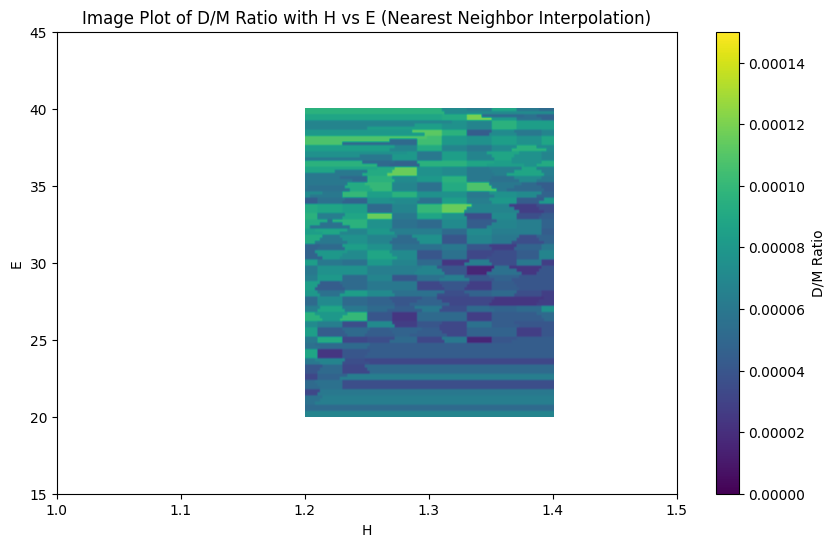

In [284]:

# Extract H, E, D, and M arrays from all_arrays
h_all = []
e_all = []
dm_all = []

for array_now in all_arrays:
    h_array = array_now[0]   # H array
    e_array = array_now[3]   # E array
    d_array = array_now[6]   # D array
    m_array = array_now[7]   # M array

    # Compute D/M ratio
    dm_ratio = np.divide(d_array, m_array, out=np.zeros_like(d_array, dtype=float), where=(m_array != 0))
    
    h_all.extend(h_array)
    e_all.extend(e_array)
    dm_all.extend(dm_ratio)

# Convert lists to numpy arrays for plotting
h_all = np.array(h_all)
e_all = np.array(e_all)
dm_all = np.array(dm_all)

# Filter out non-finite values
mask = np.isfinite(dm_all) & np.isfinite(h_all) & np.isfinite(e_all)
h_all = h_all[mask]
e_all = e_all[mask]
dm_all = dm_all[mask]

# Create a grid for H and E
h_grid = np.linspace(np.min(h_all), np.max(h_all), 100)  # 100 points in H
e_grid = np.linspace(np.min(e_all), np.max(e_all), 100)  # 100 points in E
H, E = np.meshgrid(h_grid, e_grid)

# Interpolate D/M ratio onto the grid using nearest neighbor
DM_grid = griddata((h_all, e_all), dm_all, (H, E), method='nearest')

# Set color limits (adjust as needed)
vmin = 0 #np.nanmin(dm_grid)  # Minimum value for color scale
vmax = 0.00015 # Maximum value for color scale

# Create the image plot using imshow
plt.figure(figsize=(10, 6))
plt.imshow(DM_grid, extent=(np.min(h_grid), np.max(h_grid), np.min(e_grid), np.max(e_grid)),
           origin='lower', aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar(label="D/M Ratio")
plt.xlabel("H")
plt.ylabel("E")
plt.xlim(1, 1.5)
plt.ylim(15, 45)
plt.title("Image Plot of D/M Ratio with H vs E (Nearest Neighbor Interpolation)")
plt.show()
